# Double Q-Learning

Use two Q-value function to deali with maximization bias.

In [2]:
import random
import numpy as np
        
class SlipperyWalk:
    def __init__(self):
        self.reset()

    def reset(self):
        self.observation_space = 9
        self.action_space = 2
        self._state = np.random.choice([1,2,3,4,5,6,7])
        self._done = False
        return self._state

    def step(self, action):
        if self._done: raise ValueError('Episode has terminated')
        if action not in [0, 1]: raise ValueError('Invalid action')
        
        if(action==0): direction = -1
        if(action==1): direction = 1
        
        direction_list = [direction, -direction, 0]
        true_direction = random.choices(direction_list, weights=(50, 17, 33), k=1)
        self._state += true_direction[0]
        
        reward = 0
        if self._state < 1: self._done = True
        if self._state > 7: self._done = True; reward = 1
        return self._state, reward, self._done, 0  # obs, rew, done

In [3]:
slippery_walk = SlipperyWalk()

In [4]:
optimal_V = [0., 0.5637, 0.763, 0.8449, 0.8892, 0.922, 0.9515, 0.9806, 0.]  

In [16]:
def decay_schedule(init_value, min_value, decay_steps, max_steps):
    rem_steps = max_steps - decay_steps
    values = np.logspace(start=0, stop=-2, num=decay_steps, base=10)
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

In [15]:
def decay_discounts(gamma, max_steps):
    discounts = np.logspace(start=0, stop=max_steps, num=max_steps, base=gamma, endpoint=False);
    return discounts

In [6]:
def select_action(state, Q, epsilon):
    if np.random.uniform() > epsilon:
        action = np.argmax(Q[state])
    else:
        action = np.random.randint(len(Q[0]))

    return action;

In [13]:
def double_q_learning(env,gamma=1.0, init_alpha=0.5, min_alpha=0.01, init_epsilon=1.0, min_epsilon=0.1, decay_episodes=350, n_episodes=2000):
    
    nS, nA = env.observation_space, env.action_space
    pi_track = []
    
    # two state-value functions Q1 and Q2 
    Q1 = np.zeros((nS, nA), dtype=float)
    Q2 = np.zeros((nS, nA), dtype=float)
    
    Q_track = np.zeros((n_episodes, nS, nA), dtype=float)
    V_track = np.zeros((n_episodes, nS), dtype=float)
    
    alphas = decay_schedule(init_alpha, min_alpha, decay_episodes, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, decay_episodes, n_episodes)
    
    for e in range(n_episodes):
        state, done = env.reset(), False
        while not done:
            
            # use the mean of our two Q-functions to select action 
            action = select_action(state, (Q1 + Q2)/2, epsilons[e])

            next_state, reward, done, _ = env.step(action)
            
            # flip a coin to determine an update to Q1 or Q2
            if np.random.randint(2):

                # use the action Q1 thinks is best...
                argmax_Q1 = np.argmax(Q1[next_state])
                
                # ...but get the value from Q2 to calculate the target
                td_target = reward + gamma * Q2[next_state][argmax_Q1]
                td_error = td_target - Q1[state][action]
                
                # update Q1
                Q1[state][action] = Q1[state][action] + alphas[e] * td_error
            else:
                
                # use the action Q2 thinks is best...
                argmax_Q2 = np.argmax(Q2[next_state])
                
                # ...but get the value from Q1 to calculate the target
                td_target = reward + gamma * Q1[next_state][argmax_Q2]
                td_error = td_target - Q2[state][action]
                
                # update Q2
                Q2[state][action] = Q2[state][action] + alphas[e] * td_error
            
            state = next_state
        
        Q = (Q1 + Q2)/2.
        V = np.max(Q, axis=1)
        Q_track[e] = Q
        V_track[e] = V
        
        # notice the policy is the argmax of the mean of Q1 and Q2
        pi_track.append(np.argmax((Q1 + Q2)/2, axis=1))
    
    # the final Q is the mean
    Q = (Q1 + Q2)/2.

    V = np.max(Q, axis=1)    
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, V_track, pi_track

In [17]:
Q_dq, V_dq, pi_dq, Q_track_dq, V_track_dq, pi_track_dq = double_q_learning(slippery_walk)

In [19]:
print(V_dq)

[0.         0.6012877  0.83056506 0.94148553 0.97758485 0.991386
 0.99765558 0.99936986 0.        ]


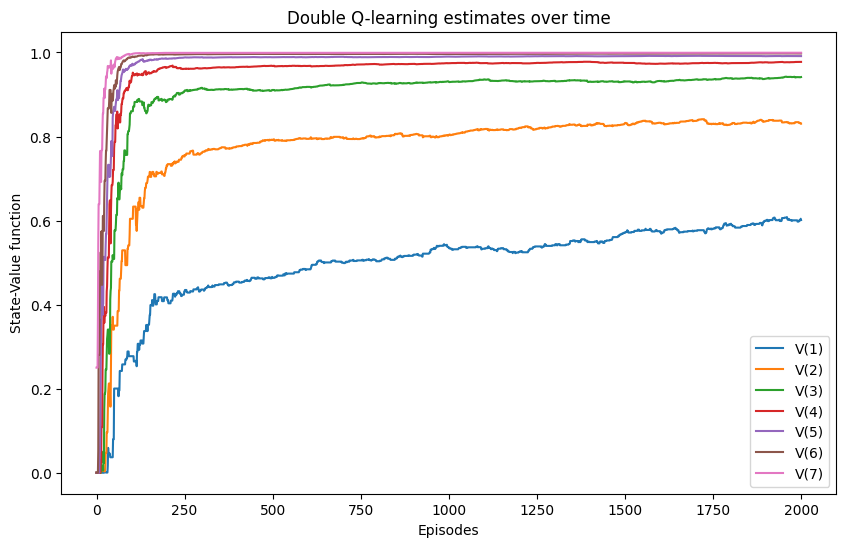

In [20]:
import matplotlib.pyplot as plt

legends = ['V(1)','V(2)','V(3)','V(4)','V(5)', 'V(6)', 'V(7)']

plt.figure(figsize=(10,6))

plt.plot(V_track_dq[:,1:8])
plt.title('Double Q-learning estimates over time')
plt.ylabel('State-Value function')
plt.xlabel('Episodes')
plt.legend(legends)

plt.show()